# **Install and Setup Library**

In [2]:
!pip install nltk Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 8.7 MB/s eta 0:00:00


In [17]:
import pandas as pd
import re
import nltk
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from collections import Counter

#visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
from collections import Counter
import ast

In [7]:
#Setup NLTK
nltk_data_dir = os.path.join(os.getcwd(), "nltk_data")
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

nltk.download('punkt', download_dir=nltk_data_dir)
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('punkt_tab', download_dir=nltk_data_dir)  # TAMBAHKAN INI
nltk.data.path.append(nltk_data_dir)


[nltk_data] Downloading package punkt to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /content/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [9]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
stop_words = set(stopwords.words('indonesian'))

# **Data preprocessing**

In [8]:
df = pd.read_csv("berita_raw_prep.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Judul Berita    285 non-null    object
 1   Text Berita     285 non-null    object
 2   Tanggal Berita  285 non-null    object
 3   Tag             285 non-null    object
 4   Link            285 non-null    object
dtypes: object(5)
memory usage: 11.3+ KB


In [10]:
def clean_basic(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<[^>]+>', ' ', text)  # HTML tags
    text = re.sub(r'http\S+|www\S+', ' ', text)  # URL
    text = re.sub(r'@[A-Za-z0-9_]+', ' ', text)  # mention
    text = re.sub(r'#[A-Za-z0-9_]+', ' ', text)  # hashtag
    text = re.sub(r'[^A-Za-zÀ-ÿ0-9\s,.!?]', ' ', text)  # simbol/emoji
    text = re.sub(r'\s+', ' ', text).strip()  # normalisasi spasi
    return text

In [11]:
def preprocess_for_sentiment_classic(text):
    text_clean = clean_basic(text.lower())
    tokens = word_tokenize(text_clean)
    before_sw = tokens.copy()
    after_sw = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return {
        "before_stopwords": ' '.join(before_sw),
        "after_stopwords": ' '.join(after_sw),
        "tokens_before_sw": before_sw,
        "tokens_after_sw": after_sw
    }

def preprocess_for_sentiment_transformer(text):
    return clean_basic(text.lower())

def preprocess_for_pos_ner(text):
    return clean_basic(text)

def tokenize_text(text):
    try:
        sentences = sent_tokenize(text)
        words = word_tokenize(text)
        return {
            "sentence_tokens": sentences,
            "word_tokens": words
        }
    except LookupError:
        # Fallback jika tokenizer masih bermasalah
        sentences = [text]
        words = text.split()
        return {
            "sentence_tokens": sentences,
            "word_tokens": words
        }


In [12]:
processed_data = []
all_tokens_after_sw = []

for i, row in df.iterrows():
    raw_text = str(row.get("Text Berita", ""))

    pos_ner_text = preprocess_for_pos_ner(raw_text)

    sentiment_classic = preprocess_for_sentiment_classic(raw_text)
    all_tokens_after_sw.extend(sentiment_classic["tokens_after_sw"])

    sentiment_transformer_text = preprocess_for_sentiment_transformer(raw_text)

    tokens = tokenize_text(pos_ner_text)

    processed_data.append({
        "Judul Berita": row.get("Judul Berita", ""),
        "Tanggal Berita": row.get("Tanggal Berita", ""),
        "Tag": row.get("Tag", ""),
        "Link": row.get("Link", ""),
        "Raw Clean (POS/NER)": pos_ner_text,
        "Sentiment Clean (Transformer)": sentiment_transformer_text,
        "Sentiment Before Stopwords": sentiment_classic["before_stopwords"],
        "Sentiment After Stopwords": sentiment_classic["after_stopwords"],
        "Tokens Before Stopwords": sentiment_classic["tokens_before_sw"],
        "Tokens After Stopwords": sentiment_classic["tokens_after_sw"],
        "Sentence Tokens": tokens["sentence_tokens"],
        "Word Tokens": tokens["word_tokens"]
    })

In [13]:
df_out = pd.DataFrame(processed_data)
df_out.to_csv("berita_preprocessed.csv", index=False, encoding="utf-8-sig")
print("Preprocessing dan Tokenization selesai. File disimpan sebagai 'berita_preprocessed.csv'")

Preprocessing dan Tokenization selesai. File disimpan sebagai 'berita_preprocessed.csv'


In [14]:
top_100 = Counter(all_tokens_after_sw).most_common(100)
top_100_df = pd.DataFrame(top_100, columns=["Word", "Frequency"])
top_100_df.to_csv("top_100_words.csv", index=False, encoding="utf-8-sig")
print("Top 100 words setelah stopwords disimpan sebagai 'top_100_words.csv'")

Top 100 words setelah stopwords disimpan sebagai 'top_100_words.csv'


In [15]:
df_out.head()

,Judul Berita,Tanggal Berita,Tag,Link,Raw Clean (POS/NER),Sentiment Clean (Transformer),Sentiment Before Stopwords,Sentiment After Stopwords,Tokens Before Stopwords,Tokens After Stopwords,Sentence Tokens,Word Tokens
0,ASDP dan Operator Ferry Swasta Perkuat Data Ma...,2025-08-12 00:00:00,"ASDP, kapal ferry, manifest penumpang, operato...",https://money.kompas.com/read/2025/08/12/15391...,"JAKARTA, KOMPAS.com Manifest penumpang dan ken...","jakarta, kompas.com manifest penumpang dan ken...","jakarta , kompas.com manifest penumpang dan ke...",jakarta kompas com manifest tumpang kendara d...,"[jakarta, ,, kompas.com, manifest, penumpang, ...","[jakarta, , kompas com, manifest, tumpang, ken...","[JAKARTA, KOMPAS.com Manifest penumpang dan ke...","[JAKARTA, ,, KOMPAS.com, Manifest, penumpang, ..."
1,"Listrik di Pulau Enggano Sudah 24 Jam, Kapal F...",2025-07-08 00:00:00,"pulau enggano, Bio Solar, Pelabuhan Pulau Baai...",https://regional.kompas.com/read/2025/07/08/10...,"BENGKULU, KOMPAS.com Kepala Desa Kaana, Alamud...","bengkulu, kompas.com kepala desa kaana, alamud...","bengkulu , kompas.com kepala desa kaana , alam...",bengkulu kompas com kepala desa kaana alamud...,"[bengkulu, ,, kompas.com, kepala, desa, kaana,...","[bengkulu, , kompas com, kepala, desa, kaana, ...","[BENGKULU, KOMPAS.com Kepala Desa Kaana, Alamu...","[BENGKULU, ,, KOMPAS.com, Kepala, Desa, Kaana,..."
2,"Ombak Hingga 2,5 Meter Hambat Pencarian KMP Tu...",2025-07-03 02:09:12+00:00,"Berita Terkini, Berita Hari Ini, Berita Harian...",https://video.kompas.com/watch/1858879/ombak-h...,"KMP Tunu Pratama Jaya tenggelam di Selat Bali,...","kmp tunu pratama jaya tenggelam di selat bali,...",kmp tunu pratama jaya tenggelam di selat bali ...,kmp tunu pratama jaya tenggelam selat bal rab...,"[kmp, tunu, pratama, jaya, tenggelam, di, sela...","[kmp, tunu, pratama, jaya, tenggelam, selat, b...",[KMP Tunu Pratama Jaya tenggelam di Selat Bali...,"[KMP, Tunu, Pratama, Jaya, tenggelam, di, Sela..."
3,Rute Ferry Batam–Johor Direncanakan Aktif Tahu...,2025-05-23 00:00:00,"kapal ferry, batam johor bahru ferry schedule,...",https://money.kompas.com/read/2025/05/23/22053...,KOMPAS.com PT Angkutan Sungai Danau dan Penyeb...,kompas.com pt angkutan sungai danau dan penyeb...,kompas.com pt angkutan sungai danau dan penyeb...,kompas com pt angkut sungai danau seberang asd...,"[kompas.com, pt, angkutan, sungai, danau, dan,...","[kompas com, pt, angkut, sungai, danau, sebera...",[KOMPAS.com PT Angkutan Sungai Danau dan Penye...,"[KOMPAS.com, PT, Angkutan, Sungai, Danau, dan,..."
4,"Menyeberangi Danau Toba, Perjalanan Naik Kapal...",2025-05-16 00:00:00,"kapal dari ajibata ke tomok, kapal ferry pelab...",https://travel.kompas.com/read/2025/05/16/0707...,KOMPAS.com Kala melihat kapal berwarna hijau t...,kompas.com kala melihat kapal berwarna hijau t...,kompas.com kala melihat kapal berwarna hijau t...,kompas com kapal warna hijau sandar labuh kem...,"[kompas.com, kala, melihat, kapal, berwarna, h...","[kompas com, kapal, warna, hijau, sandar, labu...",[KOMPAS.com Kala melihat kapal berwarna hijau ...,"[KOMPAS.com, Kala, melihat, kapal, berwarna, h..."
...,...,...,...,...,...,...,...,...,...,...,...,...
280,ASDP Waspadai Cuaca Buruk Ganggu Penyeberangan...,2022-12-23 12:32:38,"bmkg, asdp, pelabuhan merak, kapal feri, natar...",https://www.cnbcindonesia.com/news/20221223112...,"Jakarta, CNBC Indonesia BMKG mewanti wanti pot...","jakarta, cnbc indonesia bmkg mewanti wanti pot...","jakarta , cnbc indonesia bmkg mewanti wanti po...",jakarta cnbc indonesia bmkg mewanti wanti pot...,"[jakarta, ,, cnbc, indonesia, bmkg, mewanti, w...","[jakarta, , cnbc, indonesia, bmkg, mewanti, wa...","[Jakarta, CNBC Indonesia BMKG mewanti wanti po...","[Jakarta, ,, CNBC, Indonesia, BMKG, mewanti, w..."
281,Layanan ASDP Sambut Pemudik Kapal Feri di Nata...,2022-12-20 13:48:24,"asdp indonesia ferry, kapal feri",https://www.cnbcindonesia.com/news/20221220120...,"Jakarta, CNBC Indonesia PT ASDP Indonesia Ferr...","jaka

In [16]:
top_100_df.head()

,Word,Frequency
0,,8429
1,kapal,1853
2,rp,1687
3,kendara,1351
4,tumpang,1164


# **Visualization**

In [18]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['font.family'] = 'DejaVu Sans'

In [19]:
# Top 20 Kata Sebelum & Sesudah Stopwords
def visualize_top_words_comparison(df_out, top_n=20):
    # Ekstrak tokens sebelum stopwords
    all_tokens_before = []
    for tokens_list in df_out['Tokens Before Stopwords']:
        if isinstance(tokens_list, list):
            all_tokens_before.extend(tokens_list)
        elif isinstance(tokens_list, str):
            try:
                tokens = ast.literal_eval(tokens_list)
                if isinstance(tokens, list):
                    all_tokens_before.extend(tokens)
            except:
                tokens = tokens_list.strip('[]').replace("'", "").split(', ')
                all_tokens_before.extend([token.strip() for token in tokens if token.strip()])

    all_tokens_after = []
    for tokens_list in df_out['Tokens After Stopwords']:
        if isinstance(tokens_list, list):
            all_tokens_after.extend(tokens_list)
        elif isinstance(tokens_list, str):
            try:
                tokens = ast.literal_eval(tokens_list)
                if isinstance(tokens, list):
                    all_tokens_after.extend(tokens)
            except:
                tokens = tokens_list.strip('[]').replace("'", "").split(', ')
                all_tokens_after.extend([token.strip() for token in tokens if token.strip()])

    filtered_before = [token for token in all_tokens_before if len(token) > 2 and token not in ['', ' ']]
    filtered_after = [token for token in all_tokens_after if len(token) > 2 and token not in ['', ' ']]

    freq_before = Counter(filtered_before)
    freq_after = Counter(filtered_after)

    top_before = freq_before.most_common(top_n)
    top_after = freq_after.most_common(top_n)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: Top 20 sebelum stopwords
    words_before, freqs_before = zip(*top_before)
    y_pos1 = np.arange(len(words_before))

    bars1 = ax1.barh(y_pos1, freqs_before, color='orange', alpha=0.7, edgecolor='darkorange')
    ax1.set_yticks(y_pos1)
    ax1.set_yticklabels(words_before, fontsize=11, fontweight='bold')
    ax1.invert_yaxis()
    ax1.set_xlabel('Frekuensi', fontsize=12, fontweight='bold')
    ax1.set_title(f'TOP {top_n} KATA SEBELUM STOPWORDS REMOVAL',
                  fontsize=14, fontweight='bold', pad=20)
    ax1.grid(True, alpha=0.3, axis='x')

    for bar, freq in zip(bars1, freqs_before):
        width = bar.get_width()
        ax1.text(width + max(freqs_before)*0.01, bar.get_y() + bar.get_height()/2,
                f'{freq}', ha='left', va='center', fontsize=10, fontweight='bold')

    # Plot 2: Top 20 setelah stopwords
    words_after, freqs_after = zip(*top_after)
    y_pos2 = np.arange(len(words_after))

    bars2 = ax2.barh(y_pos2, freqs_after, color='blue', alpha=0.6, edgecolor='darkblue')
    ax2.set_yticks(y_pos2)
    ax2.set_yticklabels(words_after, fontsize=11, fontweight='bold')
    ax2.invert_yaxis()
    ax2.set_xlabel('Frekuensi', fontsize=12, fontweight='bold')
    ax2.set_title(f'TOP {top_n} KATA SETELAH STOPWORDS REMOVAL',
                  fontsize=14, fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.3, axis='x')

    for bar, freq in zip(bars2, freqs_after):
        width = bar.get_width()
        ax2.text(width + max(freqs_after)*0.01, bar.get_y() + bar.get_height()/2,
                f'{freq}', ha='left', va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('top_words_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    return freq_before, freq_after, len(filtered_before), len(filtered_after)

In [20]:
# Wordcloud Sebelum & Sesudah
# =============================
def visualize_wordcloud_comparison(df_out):
    text_before = ' '.join(df_out['Sentiment Before Stopwords'].dropna().astype(str))

    text_after = ' '.join(df_out['Sentiment After Stopwords'].dropna().astype(str))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Wordcloud sebelum
    wordcloud_before = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='Oranges',
        max_words=100,
        relative_scaling=0.5
    ).generate(text_before)

    ax1.imshow(wordcloud_before, interpolation='bilinear')
    ax1.set_title('WORDCLOUD SEBELUM STOPWORDS REMOVAL', fontsize=14, fontweight='bold', pad=20)
    ax1.axis('off')

    # Wordcloud sesudah
    wordcloud_after = WordCloud(
        width=800, height=400,
        background_color='white',
        colormap='Blues',
        max_words=100,
        relative_scaling=0.5
    ).generate(text_after)

    ax2.imshow(wordcloud_after, interpolation='bilinear')
    ax2.set_title('WORDCLOUD SETELAH STOPWORDS REMOVAL', fontsize=14, fontweight='bold', pad=20)
    ax2.axis('off')

    plt.tight_layout()
    plt.savefig('wordcloud_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()


In [21]:
# Distribusi Top 10 Kata Hasil Preprocessing
def visualize_top10_distribution(df_out):
    all_tokens_after = []
    for tokens_list in df_out['Tokens After Stopwords']:
        if isinstance(tokens_list, list):
            all_tokens_after.extend(tokens_list)
        elif isinstance(tokens_list, str):
            try:
                tokens = ast.literal_eval(tokens_list)
                if isinstance(tokens, list):
                    all_tokens_after.extend(tokens)
            except:
                tokens = tokens_list.strip('[]').replace("'", "").split(', ')
                all_tokens_after.extend([token.strip() for token in tokens if token.strip()])

    filtered_after = [token for token in all_tokens_after if len(token) > 2 and token not in ['', ' ']]

    freq_after = Counter(filtered_after)
    top_10 = freq_after.most_common(10)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Pie Chart
    words, freqs = zip(*top_10)
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFD700', '#FFA07A',
              '#20B2AA', '#FF69B4', '#BA55D3', '#F0E68C', '#98FB98']

    wedges, texts, autotexts = ax1.pie(freqs, labels=words, autopct='%1.1f%%',
                                      startangle=90, colors=colors,
                                      textprops={'fontsize': 10, 'fontweight': 'bold'})

    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')

    ax1.set_title('DISTRIBUSI TOP 10 KATA HASIL PREPROCESSING', fontsize=14, fontweight='bold', pad=20)

    y_pos = np.arange(len(words))
    bars = ax2.barh(y_pos, freqs, color=colors, alpha=0.7, edgecolor='black')

    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(words, fontsize=11, fontweight='bold')
    ax2.invert_yaxis()
    ax2.set_xlabel('Frekuensi', fontsize=12, fontweight='bold')
    ax2.set_title('TOP 10 KATA PALING SERING MUNCUL', fontsize=14, fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.3, axis='x')

    for bar, freq in zip(bars, freqs):
        width = bar.get_width()
        ax2.text(width + max(freqs)*0.01, bar.get_y() + bar.get_height()/2,
                f'{freq}', ha='left', va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('top10_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    return len(freq_after), len(filtered_after)

In [22]:
# Distribusi Panjang Teks Sebelum & Sesudah
# =============================
def visualize_text_length_distribution(df_out):
    before_lengths = []
    after_lengths = []

    for before_tokens, after_tokens in zip(df_out['Tokens Before Stopwords'], df_out['Tokens After Stopwords']):
        # Convert to list jika perlu
        if isinstance(before_tokens, str):
            before_tokens = ast.literal_eval(before_tokens)
        if isinstance(after_tokens, str):
            after_tokens = ast.literal_eval(after_tokens)

        before_lengths.append(len(before_tokens))
        after_lengths.append(len(after_tokens))

    # Buat visualisasi
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Histogram perbandingan
    ax1.hist(before_lengths, bins=30, alpha=0.7, color='orange', label='Sebelum Preprocessing', edgecolor='darkorange')
    ax1.hist(after_lengths, bins=30, alpha=0.6, color='blue', label='Sesudah Preprocessing', edgecolor='darkblue')
    ax1.set_xlabel('Jumlah Tokens per Dokumen', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Frekuensi Dokumen', fontsize=12, fontweight='bold')
    ax1.set_title('DISTRIBUSI PANJANG TEKS\nSEBELUM vs SESUDAH PREPROCESSING', fontsize=14, fontweight='bold', pad=20)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Box plot
    box_data = [before_lengths, after_lengths]
    box_labels = ['Sebelum', 'Sesudah']
    box_colors = ['orange', 'blue']

    boxes = ax2.boxplot(box_data, labels=box_labels, patch_artist=True,
                       boxprops=dict(facecolor='lightgray', color='black'),
                       medianprops=dict(color='red', linewidth=2),
                       whiskerprops=dict(color='black'),
                       capprops=dict(color='black'))

    # Warna box
    for patch, color in zip(boxes['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    ax2.set_ylabel('Jumlah Tokens', fontsize=12, fontweight='bold')
    ax2.set_title('BOX PLOT PANJANG TEKS', fontsize=14, fontweight='bold', pad=20)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('text_length_distribution.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    # Hitung statistik
    stats_before = {
        'rata_rata': np.mean(before_lengths),
        'median': np.median(before_lengths),
        'std_dev': np.std(before_lengths),
        'min': np.min(before_lengths),
        'max': np.max(before_lengths)
    }

    stats_after = {
        'rata_rata': np.mean(after_lengths),
        'median': np.median(after_lengths),
        'std_dev': np.std(after_lengths),
        'min': np.min(after_lengths),
        'max': np.max(after_lengths)
    }

    return stats_before, stats_after

VISUALISASI HASIL PREPROCESSING
Data shape: (285, 12)

1. TOP 20 KATA PERBANDINGAN


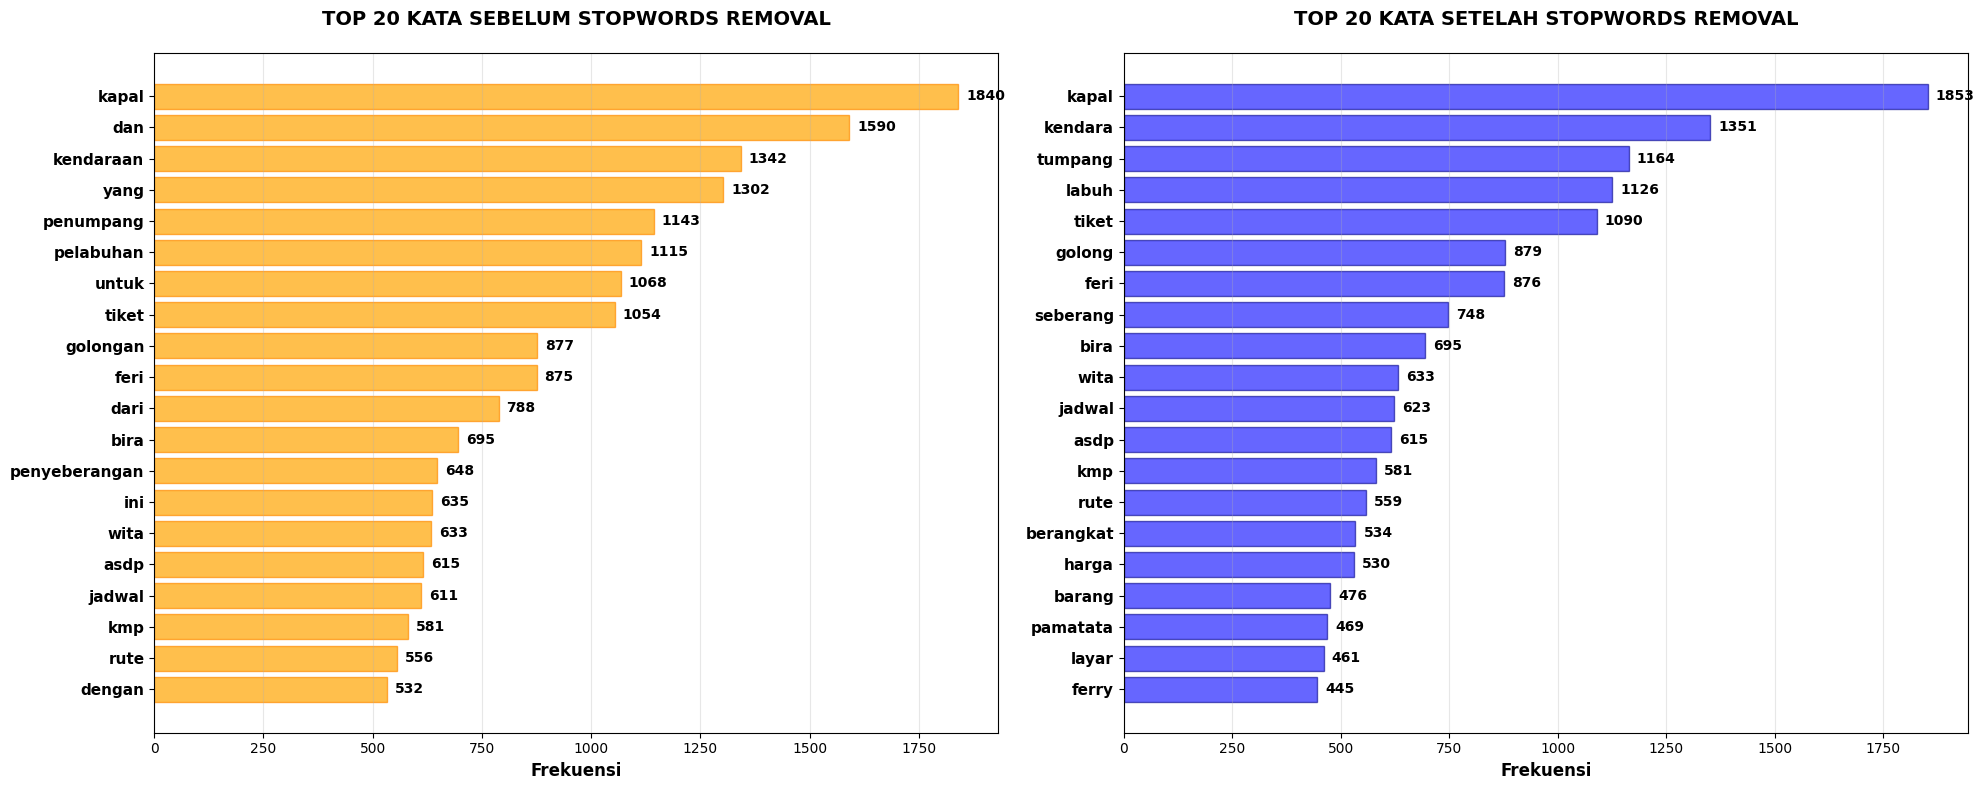


2. WORDCLOUD COMPARISON


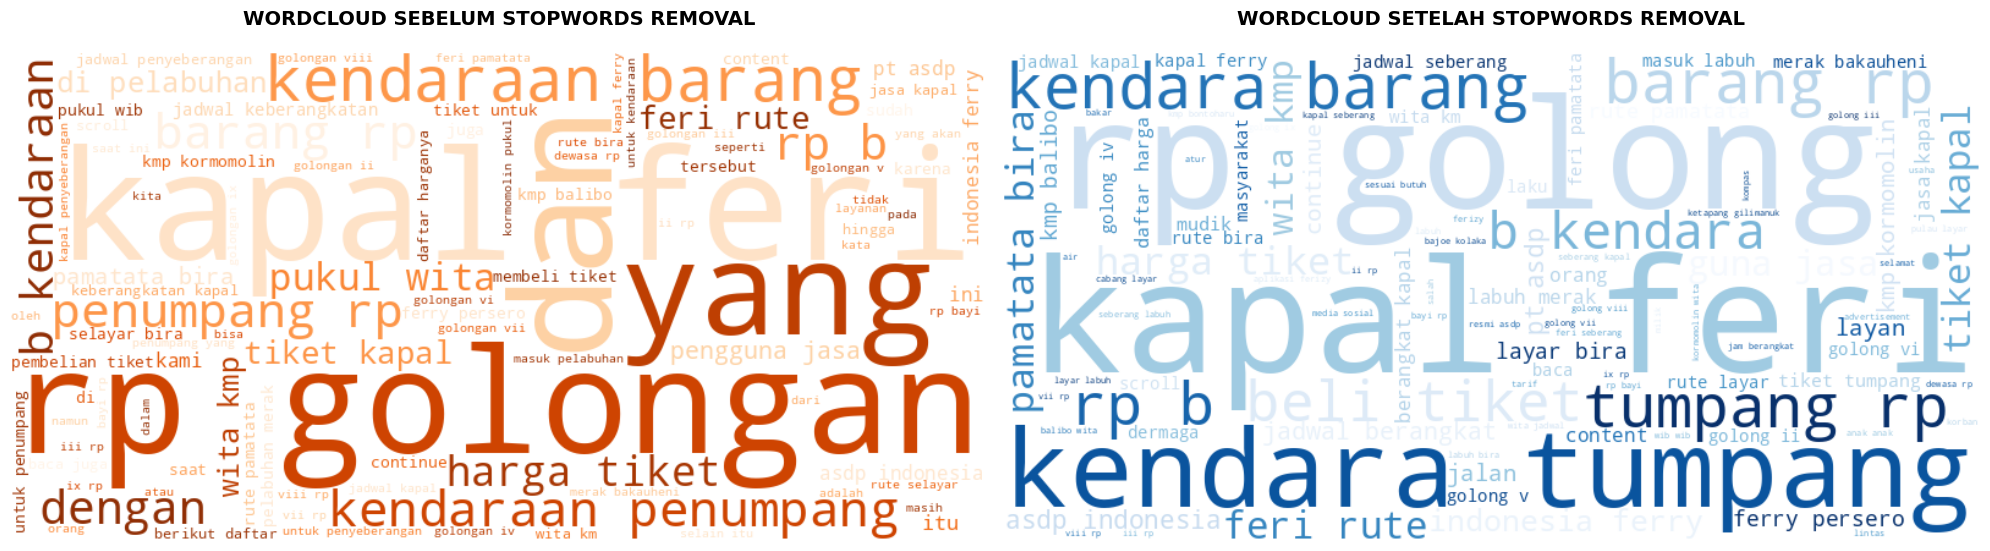


3. DISTRIBUSI TOP 10 KATA


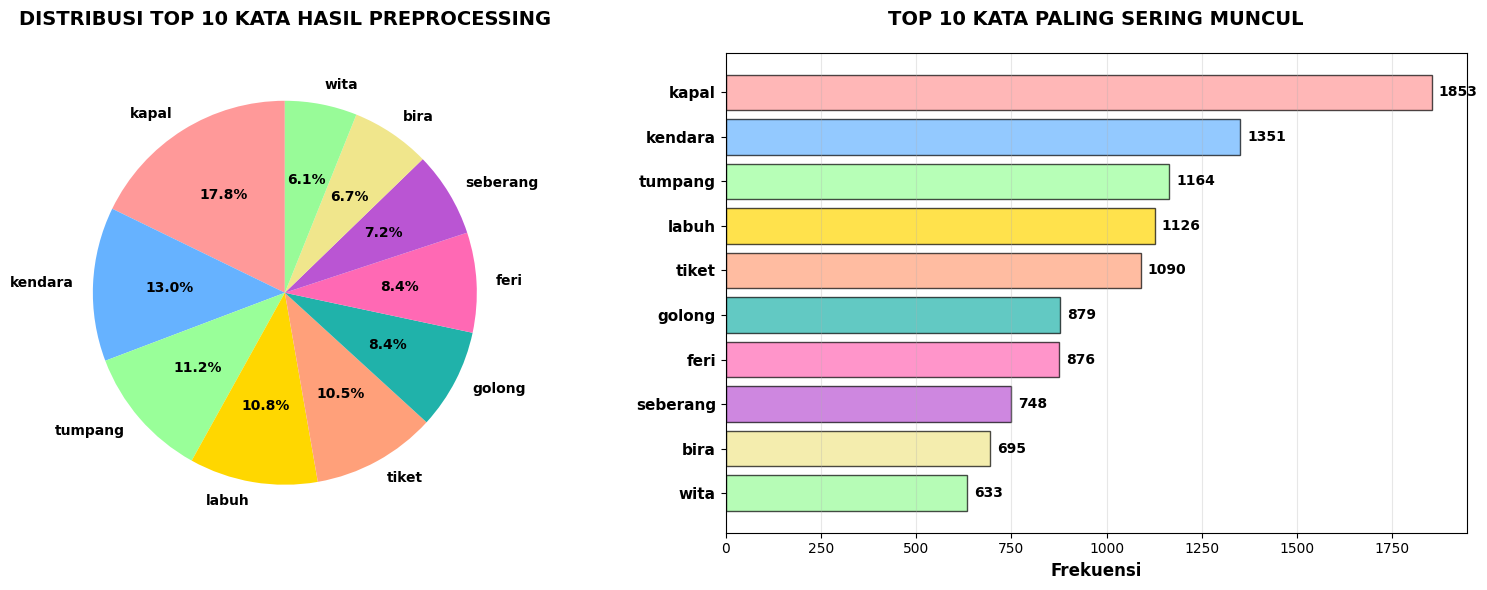


4. DISTRIBUSI PANJANG TEKS


/tmp/ipython-input-907729988.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxes = ax2.boxplot(box_data, labels=box_labels, patch_artist=True,


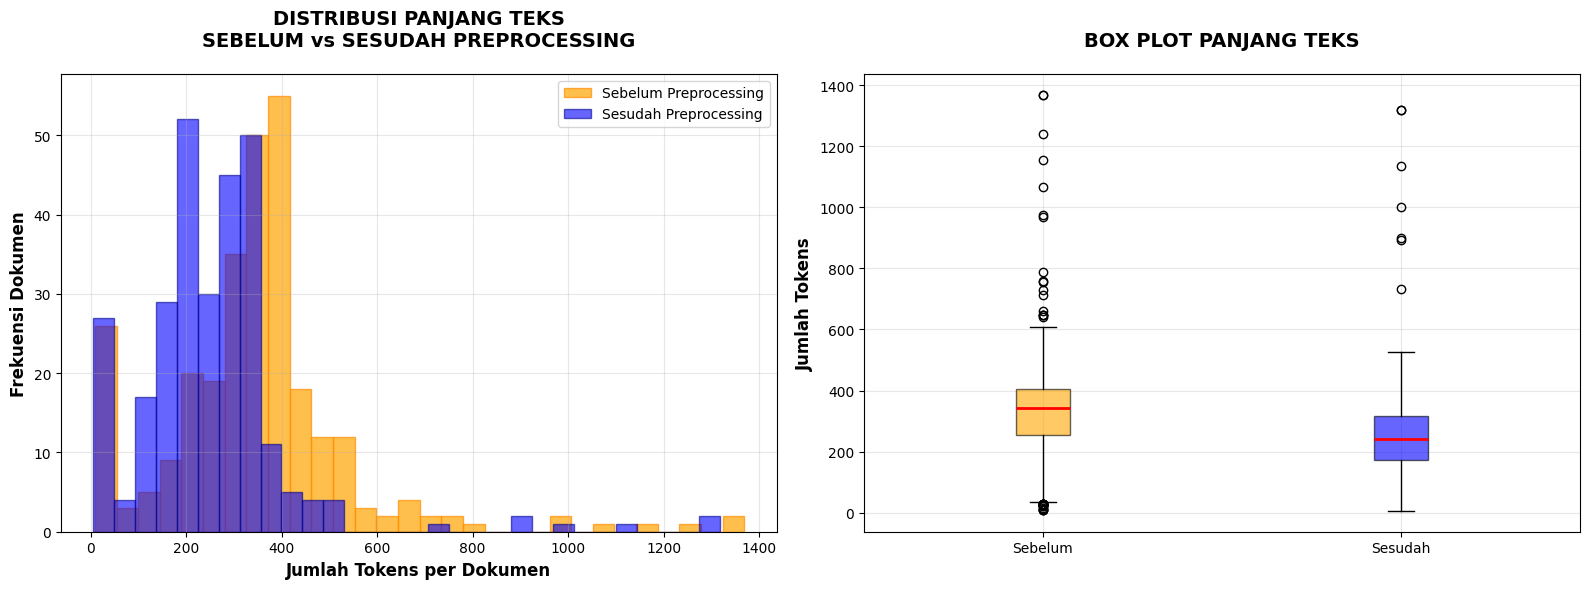


📋 SUMMARY STATISTIK

 TOKEN STATISTICS:
   - Total tokens unik: 4327
   - Total semua tokens: 56621
   - Token sebelum stopwords: 81889
   - Token setelah stopwords: 56621
   - Reduksi: 30.86%

 STATISTIK PANJANG DOKUMEN SEBELUM:
   - Rata-rata: 348.16 tokens
   - Median: 344.00 tokens
   - Std Dev: 198.81 tokens
   - Min: 9 tokens
   - Max: 1369 tokens

 STATISTIK PANJANG DOKUMEN SESUDAH:
   - Rata-rata: 252.65 tokens
   - Median: 240.00 tokens
   - Std Dev: 168.40 tokens
   - Min: 6 tokens
   - Max: 1318 tokens


In [25]:
def main():
    print("VISUALISASI HASIL PREPROCESSING")
    print("="*50)

    try:
        # Load data
        print(f"Data shape: {df_out.shape}")

        # 1. Top 20 Kata Sebelum & Sesudah
        print("\n" + "="*40)
        print("1. TOP 20 KATA PERBANDINGAN")
        print("="*40)
        freq_before, freq_after, total_before, total_after = visualize_top_words_comparison(df_out)

        # 2. Wordcloud Sebelum & Sesudah
        print("\n" + "="*40)
        print("2. WORDCLOUD COMPARISON")
        print("="*40)
        visualize_wordcloud_comparison(df_out)

        # 3. Distribusi Top 10 Kata
        print("\n" + "="*40)
        print("3. DISTRIBUSI TOP 10 KATA")
        print("="*40)
        unique_tokens, total_tokens = visualize_top10_distribution(df_out)

        # 4. Distribusi Panjang Teks
        print("\n" + "="*40)
        print("4. DISTRIBUSI PANJANG TEKS")
        print("="*40)
        stats_before, stats_after = visualize_text_length_distribution(df_out)

        # PRINT SUMMARY STATISTIK
        print("\n" + "="*60)
        print("📋 SUMMARY STATISTIK")
        print("="*60)

        print(f"\n TOKEN STATISTICS:")
        print(f"   - Total tokens unik: {unique_tokens}")
        print(f"   - Total semua tokens: {total_tokens}")
        print(f"   - Token sebelum stopwords: {total_before}")
        print(f"   - Token setelah stopwords: {total_after}")
        print(f"   - Reduksi: {((total_before - total_after) / total_before * 100):.2f}%")

        print(f"\n STATISTIK PANJANG DOKUMEN SEBELUM:")
        print(f"   - Rata-rata: {stats_before['rata_rata']:.2f} tokens")
        print(f"   - Median: {stats_before['median']:.2f} tokens")
        print(f"   - Std Dev: {stats_before['std_dev']:.2f} tokens")
        print(f"   - Min: {stats_before['min']} tokens")
        print(f"   - Max: {stats_before['max']} tokens")

        print(f"\n STATISTIK PANJANG DOKUMEN SESUDAH:")
        print(f"   - Rata-rata: {stats_after['rata_rata']:.2f} tokens")
        print(f"   - Median: {stats_after['median']:.2f} tokens")
        print(f"   - Std Dev: {stats_after['std_dev']:.2f} tokens")
        print(f"   - Min: {stats_after['min']} tokens")
        print(f"   - Max: {stats_after['max']} tokens")



    except Exception as e:
        print(f"Error: {e}")
        print("Pastikan kode preprocessing sudah dijalankan")

# Jalankan visualisasi
if __name__ == "__main__":
    main()